In [35]:
# https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers
import torch
import torch.nn as nn
import torchtext
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.nn import functional as F
import torch.optim as optim

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import math
from torch.utils.data import Dataset, DataLoader
import torch.utils.data.dataloader as dataloader
import os
import re

In [36]:
root = "/kaggle/input/movies"

In [1]:
with open(os.path.join(root, "reviews.csv"), encoding='latin-1') as f:
        with open(os.path.join("/kaggle/working", "data.txt"), "w") as f2:
            for line in f:
                text_only = "".join(line.split(",")[:-1])
                filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # Replaces double quotes with a space, and \n with a space
                # Replaces \\, \\n, and; with a space
                # Replaces HTML codes with real characters
                filtered = filtered.replace(' #39;', "'")
                filtered = filtered.replace(' #38;', "&")
                filtered = filtered.replace(' #36;', "$")
                filtered = filtered.replace(' #151;', "-")
                f2.write(filtered.lower() + "\n")

In [ ]:
# Generate the SentencePiece tokenizer
# Text tokenizer and detokenizer
# It will tokenize words into subpieces instead of words
# This function will create a set of subtokens to fit the set vocabulary size
# There will always be enough subwords to subtokenize a dataset if you think about it :) -> max 2 length pairs = 26!
# Saved in the home directory
generate_sp_model(os.path.join("/kaggle/working", "data.txt"), vocab_size=30000, model_prefix='/kaggle/working/transformer')

In [ ]:
class IMDB(Dataset):
    def __init__(self, root):
        self.root = root

        # Reads the file into a pandas DataFrame with Latin-1 encoding
        self.df = pd.read_csv(os.path.join(root, "reviews.csv"), names=["Article", "Class"], encoding='latin-1')

        # Replaces empty entries with a space
        self.df.fillna('', inplace=True)

        # Clean the 'Article' column
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['Article'] = self.df['Article'].replace({' #39;': "'", ' #38;': "&", ' #36;': "$", ' #151;': "-"}, regex=True)

    # To use for DataLoader
    def __getitem__(self, index):
        text = self.df.loc[index]["Article"].lower()
        
        class_label = self.df.loc[index]["Class"]

        if class_label == 'positive':
            class_index = 1
        else:
            class_index = 0
            
        return class_label, text

    def __len__(self):
        return len(self.df)

# Example usage:
train_dataset = IMDB(root)
print(len(train_dataset))
print(train_dataset.df.loc[0]["Article"])
print(train_dataset.df.loc[0]["Class"])


In [ ]:
# Split 90% - 10%
validation_split = 0.9

# Total train examples
n_train_examples = int(len(train_dataset) * validation_split)

# Total validation examples
n_valid_examples = len(train_dataset) - n_train_examples

# Splits them based on values provided
train_data, valid_data = torch.utils.data.random_split(train_dataset, [n_train_examples, n_valid_examples], generator=torch.Generator().manual_seed(42))

In [ ]:
# Create dataloaders for the training and testing datasets
# Dataloaders allow for batching, shuffling

batch_size = 128

train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)

test_loader = dataloader.DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [ ]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Accesses the vocab file, splits the line by tab, and gets the first entry (the actual token)
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
vocab = build_vocab_from_iterator(yield_tokens("/kaggle/working/transformer.vocab"), specials=['<cls>', '<pad>', '<eos>', '<unk>'], special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [ ]:
# Maximum sequence length for text inputs
max_len = 256

# Data transform to turn text into vocab tokens
text_transform = T.Sequential(
    # Tokenize with pre-existing Tokenizer
    T.SentencePieceTokenizer("/kaggle/working/transformer.model"),
    # Converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> at the beginning of each sentence. 1 because the index for <sos> in the vocabulary is 1 as seen in previous section
    T.AddToken(vocab['<sos>'], begin=True),
    # Crop the sentence if it is longer than the max length minus 2 to accommodate <sos> and <eos> tokens
    T.Truncate(max_seq_len=max_len-2),
    # Add <eos> at the end of each sentence. 2 because the index for <eos> in the vocabulary is 2 as seen in previous section
    T.AddToken(vocab['<eos>'], begin=False),
    # Convert the list of lists to a tensor. This will also pad a sentence with the <pad> token if it is shorter than the max length.
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=vocab['<pad>']),
    # Pad the sequence to ensure it's exactly max_len tokens long
    T.PadTransform(max_length=max_len, pad_value=0),
)

In [47]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

In [48]:
class Block(nn.Module):
    # Transformer followed by computation
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # Residual connection
        x = x + self.ffwd(self.ln2(x))
        return x

In [49]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
#         self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
#         wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

In [50]:
"""
Defines multi-head attention, given num_heads
"""
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))
        return out

In [51]:
class Transformer(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # Each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size + 1, n_embd)
                                                    
        # self.sa_heads = MultiHeadAttention(4, n_embd//4) # Four heads, 8-dim self-attention
        # self.ffwd = FeedForward(n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, output_size)
 
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T, C)
        x = tok_emb + pos_emb # (B,T,C) -> broadcasted
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) # (B, T, output_size)

        return logits

In [54]:
# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
block_size = 256
n_embd = 768
n_head = 12
n_layer = 2
dropout = 0.3
nepochs = 100
output_size = 2
vocab_size = len(vocab)
learning_rate = 5e-4

In [55]:
# Define the model

model = Transformer()

model.to(device)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

loss_fn = nn.CrossEntropyLoss()

training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

In [56]:
# Training Loop
# Train for 10 epochs or so... first
train_acc = 0
test_acc = 0

for epoch in range(nepochs):

    model.train()
    
    print("training")
    
    train_acc_count = 0
    test_acc_count = 0
    train_steps = 0
    
    for labels, texts in train_loader:
        text_tokens = text_transform(list(texts)).to(device)
        labels = labels.to(device)
        logits = model(text_tokens)
        loss = F.cross_entropy(logits[:, 0, :], labels)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
#         print(loss)
    
        # Log the training loss
        training_loss_list.append(loss.item())
        
        # Update training accuracy
        train_acc_count += (logits[:, 0, :].argmax(1) == labels).sum().item()
        train_steps += batch_size
    
    # Calculate average training accuracy
    train_acc = (train_acc_count / train_steps)
    training_acc_list.append(train_acc)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Set the model to evaluation mode
    model.eval()
    
    print("evaluating")
    train_acc_count = 0
    test_acc_count = 0
    test_steps = 0
    
    
    with torch.no_grad():
        for labels, texts in test_loader:
            text_tokens = text_transform(list(texts)).to(device)
            labels = labels.to(device)
            logits = model(text_tokens)
            loss = F.cross_entropy(logits[:, 0, :], labels)
            
            test_acc_count += (logits[:, 0, :].argmax(1) == labels).sum().item()
            test_steps += batch_size
        
        # Calculate average testing accuracy
        test_acc = (test_acc_count / test_steps)
        test_acc_list.append(test_acc)

    # Print out the results for this epoch
    print(f'Epoch {epoch+1}/{nepochs}')
    print(f'Training Accuracy: {train_acc*100:.2f}%')
    print(f'Testing Accuracy: {test_acc*100:.2f}%')

training
evaluating
Epoch 1/100
Training Accuracy: 69.04%
Testing Accuracy: 77.58%
training
evaluating
Epoch 2/100
Training Accuracy: 80.08%
Testing Accuracy: 79.93%
training
evaluating
Epoch 3/100
Training Accuracy: 82.24%
Testing Accuracy: 82.41%
training
evaluating
Epoch 4/100
Training Accuracy: 83.78%
Testing Accuracy: 83.17%
training
evaluating
Epoch 5/100
Training Accuracy: 84.99%
Testing Accuracy: 84.15%
training
evaluating
Epoch 6/100
Training Accuracy: 86.07%
Testing Accuracy: 84.40%
training
evaluating
Epoch 7/100
Training Accuracy: 86.91%
Testing Accuracy: 84.76%
training
evaluating
Epoch 8/100
Training Accuracy: 87.85%
Testing Accuracy: 83.89%
training
evaluating
Epoch 9/100
Training Accuracy: 88.54%
Testing Accuracy: 85.38%
training
evaluating
Epoch 10/100
Training Accuracy: 89.16%
Testing Accuracy: 83.33%
training
evaluating
Epoch 11/100
Training Accuracy: 90.12%
Testing Accuracy: 85.46%
training
evaluating
Epoch 12/100
Training Accuracy: 90.49%
Testing Accuracy: 84.54%
t

KeyboardInterrupt: 

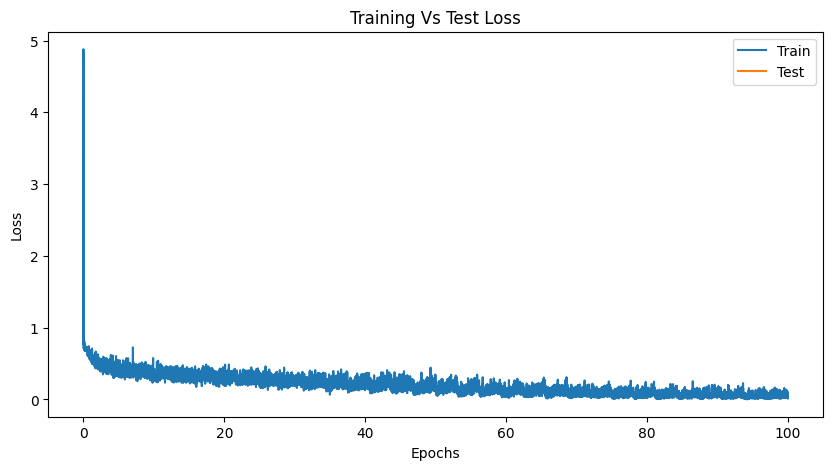

In [57]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_list)), training_loss_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_list)), test_loss_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

In [58]:
# Save the model
torch.save(model.state_dict(), 'transformer_sentiment_analysis.pth')

Max Test Accuracy 85.96%


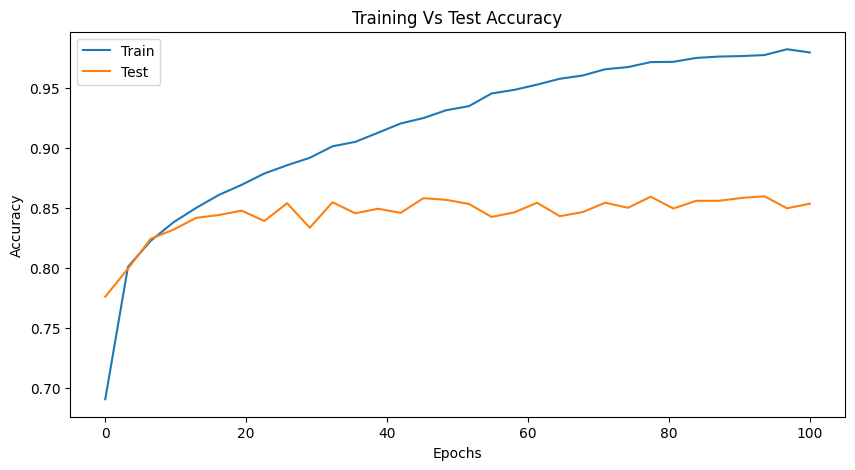

In [59]:
# Have to run atleast one epoch fully through
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_list)), training_acc_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_list)), test_acc_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_list) * 100))